In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Load the test data
y_test = pd.read_csv('data/processed/y_test_ml.csv')

# Load the model results dictionary
with open('models/model_results.pkl', 'rb') as f:
    model_results = pickle.load(f)

In [3]:
# Create a function to evaluate and display results
def evaluate_model(y_true, y_pred, y_proba=None):
    """Evaluate model performance with multiple metrics"""
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, zero_division=0)
    
    if y_proba is not None:
        results['auc'] = roc_auc_score(y_true, y_proba)
    
    return results

,accuracy,precision,recall,f1,auc
random_forest,0.994460,0.994152,0.994152,0.994152,0.999831
xgboost,0.988920,0.988304,0.988304,0.988304,0.998923
neural_network,0.991690,0.988372,0.994152,0.991254,0.999354
ft_transformer,0.994460,0.994152,0.994152,0.994152,0.999846
tab_transformer,0.986150,0.977011,0.994152,0.985507,0.999723


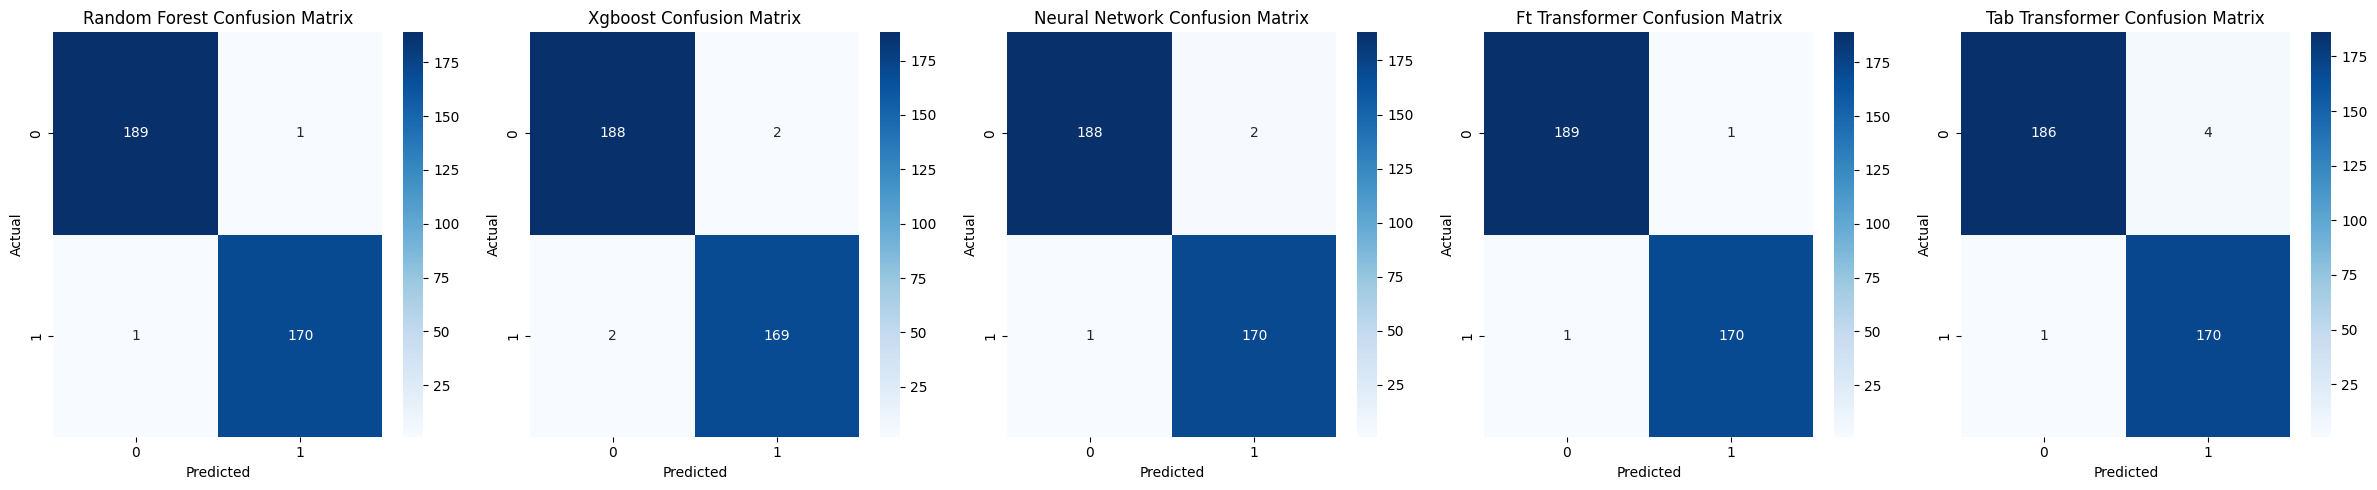

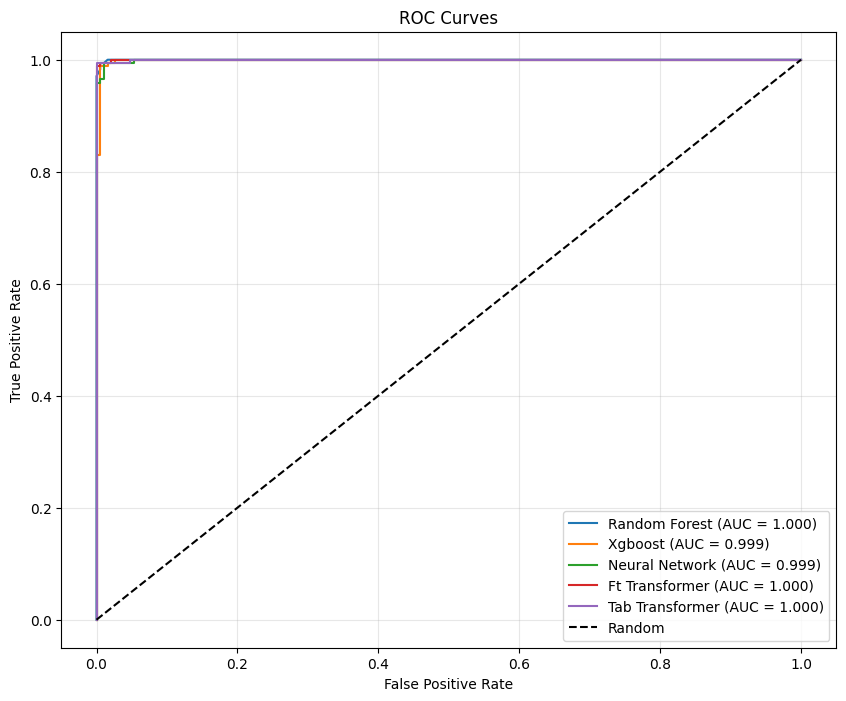

In [4]:


# Update the models list to include the FT Transformer
models = ['random_forest', 'xgboost', 'neural_network', 'ft_transformer', 'tab_transformer']

# Recalculate evaluation results for all models including FT Transformer
evaluation_results = {}

for model in models:
    test_preds = model_results[model]['test_preds']
    test_proba = model_results[model]['test_proba']
    evaluation_results[model] = evaluate_model(y_test, test_preds, test_proba)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(evaluation_results).T
display(results_df.style.highlight_max(axis=0))

# Redraw confusion matrices with FT Transformer
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for i, model in enumerate(models):
    cm = confusion_matrix(y_test, model_results[model]['test_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model.replace("_", " ").title()} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Redraw ROC curves including FT Transformer
plt.figure(figsize=(10, 8))

for model in models:
    y_proba = model_results[model]['test_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model.replace("_", " ").title()} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Feature importance for Random Forest model (optional)
if 'random_forest' in model_results:
    # Load the Random Forest model
    with open('models/random_forest_model.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()